In [1]:
import numpy as np
import pandas as pd
from utils import read_q_mat, read_a_mat
import scipy.io
from sim import (
    model_setup,
    sim_hb,
    std_operating_policy,
    max_release,
    min_release,
    level_to_storage,
)
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import OF_flood, OF_hydro
import os
from process_policy import find_best_policy, plot_policy, process_policy, plot_policy_ts
from itertools import product


import warnings

warnings.filterwarnings("ignore")

# Current performance quantification
## Setting up the model


In [2]:
start_date = "1994-11-01"
end_date = "2007-01-01"
q_vu = "/Users/cooper/Desktop/optimal-wat-allocation/data/q_vuquang.mat"
q_ye = "/Users/cooper/Desktop/optimal-wat-allocation/data/q_yenbai.mat"
a = "/Users/cooper/Desktop/optimal-wat-allocation/data/a_hoabinh_K.mat"

qq, sys_params = model_setup(
    ini_date=start_date,
    fin_date=end_date,
    path_a_hoabinh_K=a,
    path_q_vuquang=q_vu,
    path_q_yenbai=q_ye,
)

## Plotting the current control policy


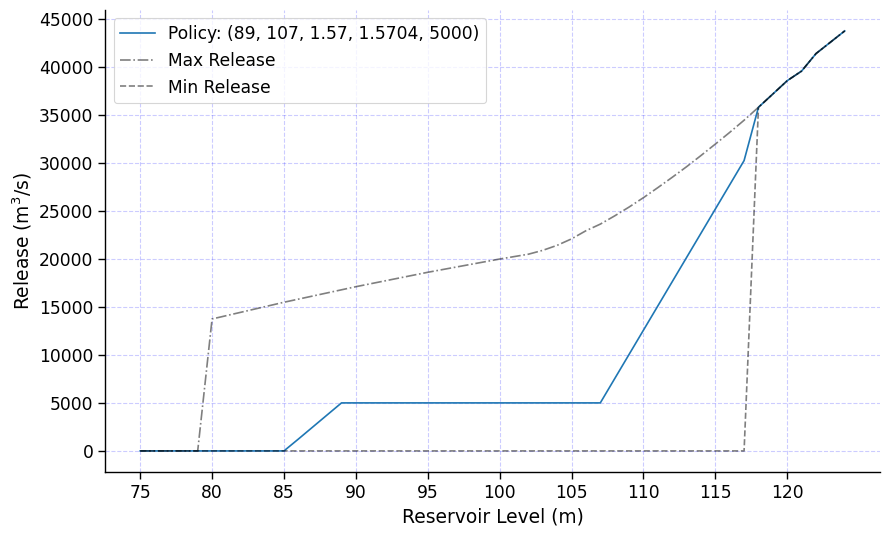

In [3]:
control_policy = (89, 107, 1.57, 1.5704, 5000)

plot_policy(policies=[control_policy], sys_params=sys_params)

## Plotting the time series of simulated reservoir level, release, and water level in Hanoi for the period 1995-2006.


In [4]:
control_policy_simul = process_policy(
    path_to_policy="/Users/cooper/Desktop/optimal-wat-allocation/data/simHB_output.csv",
    start_date=start_date,
    end_date=end_date,
)

control_policy_simul = control_policy_simul["1995":"2006"]
control_policy_simul

,ReservoirLevel,ReleaseDecision,Release,WaterLevelHanoi
Date,,,,
1995-01-01,85.643921,785.551161,804.235152,3.415327
1995-01-02,85.614685,748.837769,785.551161,3.411999
1995-01-03,85.606837,738.982871,748.837769,3.348751
1995-01-04,85.626696,763.921157,738.982871,3.364501
1995-01-05,85.741300,907.836437,763.921157,3.667345
...,...,...,...,...
2006-12-27,85.419935,504.277673,514.862006,2.051027
2006-12-28,85.411271,493.397313,504.277673,2.040744
2006-12-29,85.390629,467.476096,493.397313,2.148142


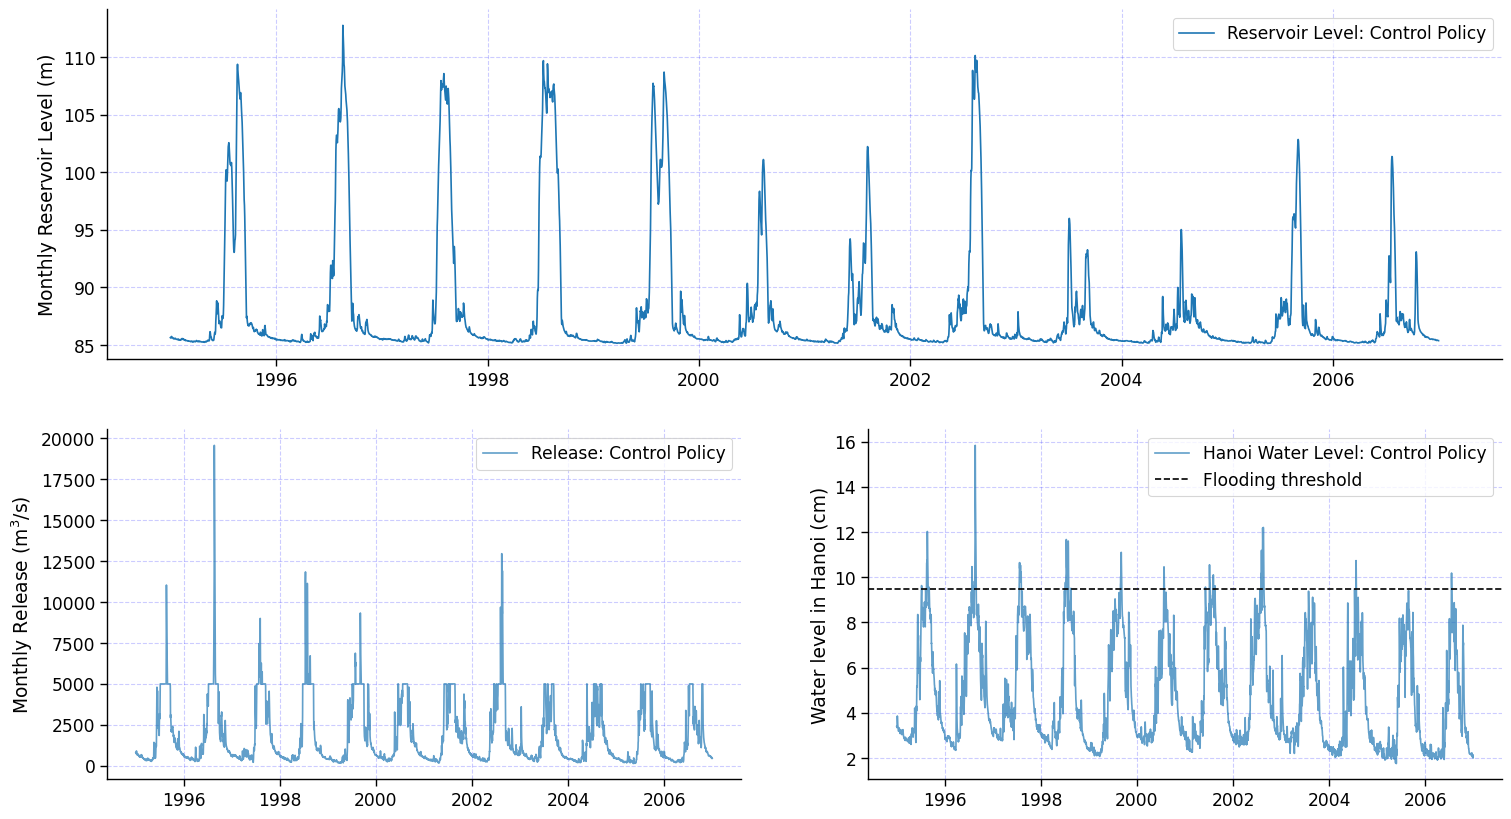

In [5]:
policy1 = plot_policy_ts(
    [control_policy_simul],
    ["Control Policy"],
    "/Users/cooper/Desktop/optimal-wat-allocation/images/control_policy.png",
)

## Computing the current performance in the two operating objectives


In [6]:
j_flood = OF_flood(control_policy_simul["WaterLevelHanoi"] * 100)

j_hydro = OF_hydro(
    qq["q_Da"]["1995":"2006"],
    control_policy_simul["Release"],
    control_policy_simul["ReservoirLevel"],
)

print(f"j_flood: {j_flood} [cm2]")
print(f"j_hydro: {j_hydro} [GWh]")

j_flood: 525.77 [cm2]
j_hydro: 16.73 [GWh]


# Exhaustive optimisation on a Finite Policy Parameters Set
## Creating the set of policy parameters

In [7]:
h1 = 89
h2_values = [100, 105, 110, 115]
m1 = 1.57
m2_values = [1.56, 1.565, 1.57]
w_values = [500, 1000, 1500, 2000, 3000, 8000, 13000]

combinations = list(product([h1], h2_values, [m1], m2_values, w_values))


policies_df = pd.DataFrame(combinations, columns=["h1", "h2", "m1", "m2", "w"])

policies_df["Policy"] = policies_df.apply(tuple, axis=1)
policies_df = policies_df[["Policy"]]

policies_df

,Policy
0,"(89.0, 100.0, 1.57, 1.56, 500.0)"
1,"(89.0, 100.0, 1.57, 1.56, 1000.0)"
2,"(89.0, 100.0, 1.57, 1.56, 1500.0)"
3,"(89.0, 100.0, 1.57, 1.56, 2000.0)"
4,"(89.0, 100.0, 1.57, 1.56, 3000.0)"
...,...
79,"(89.0, 115.0, 1.57, 1.57, 1500.0)"
80,"(89.0, 115.0, 1.57, 1.57, 2000.0)"
81,"(89.0, 115.0, 1.57, 1.57, 3000.0)"
82,"(89.0, 115.0, 1.57, 1.57, 8000.0)"


## Finding the best policy for hydropower, the best for flood control, and the best compromise

In [8]:
compromise = find_best_policy(
    criteria="compromise",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

compromise_policy = policies_df.iloc[compromise['policy']-1]['Policy']


flood = find_best_policy(
    criteria="flood",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

flood_policy = policies_df.iloc[flood['policy']-1]['Policy']

hydro = find_best_policy(
    criteria="hydro",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

hydro_policy = policies_df.iloc[hydro['policy']-1]['Policy']

## Getting the simulation time series

In [9]:
compromise_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{compromise['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

compromise_policy_simul = compromise_policy_simul["1995":"2006"]

flood_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{flood['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

flood_policy_simul = flood_policy_simul["1995":"2006"]

hydro_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{hydro['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

hydro_policy_simul = hydro_policy_simul["1995":"2006"]


## Plotting all three policies and the time series of simulated reservoir level, release, and water level in Hanoi for the period 1995-2006.

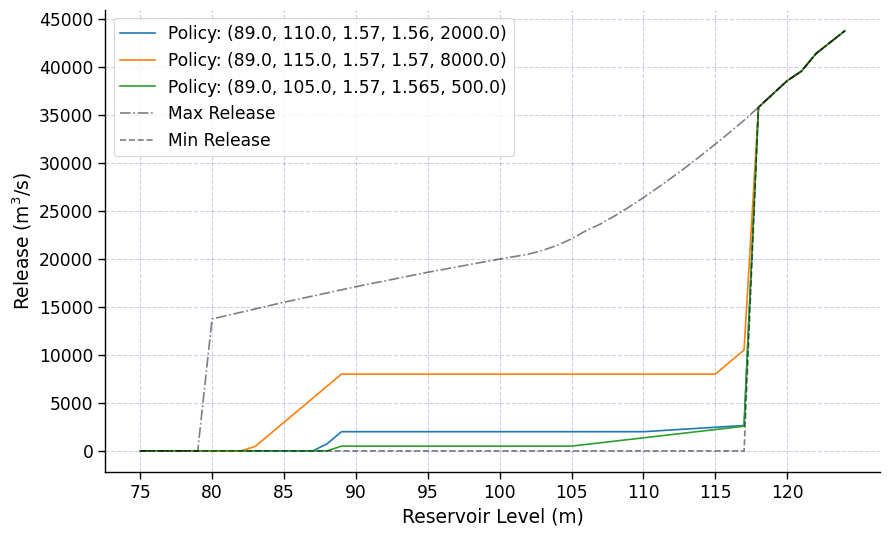

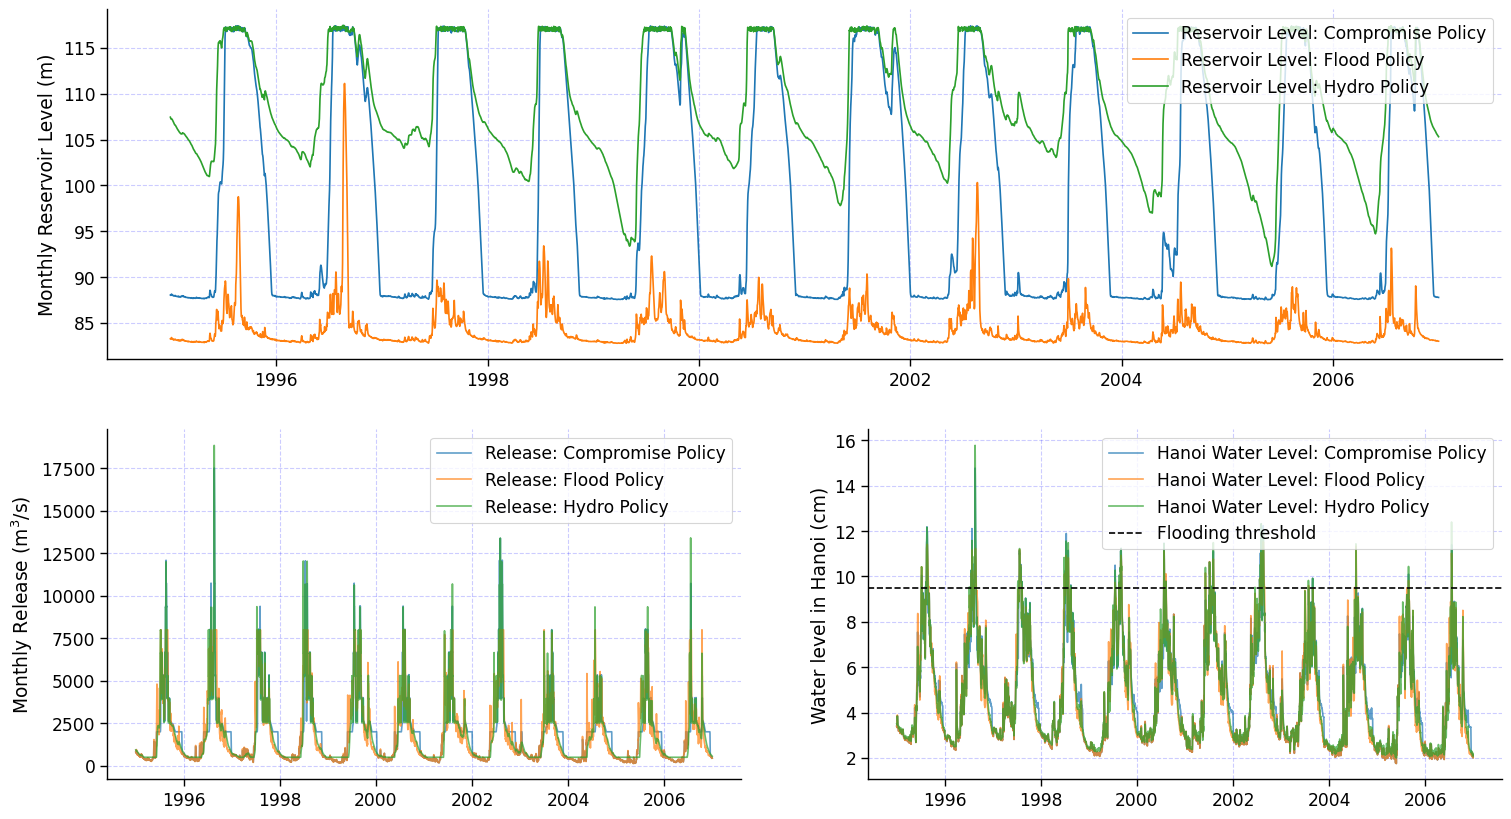

In [10]:
plot_policy(
    policies=[compromise_policy, flood_policy, hydro_policy],
    sys_params=sys_params,
    output_destination="/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_policies.png",
    names=["Compromise Policy", "Flood Policy", "Hydro Policy"],
)

plot_policy_ts(
    [compromise_policy_simul, flood_policy_simul, hydro_policy_simul],
    ["Compromise Policy", "Flood Policy", "Hydro Policy"],
    "/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_TS.png",
)